# Decoding using the CSP

Features are extracted using the Common Spatial pattern (CSP) filtered signals

CSP is based on a decompostion of the EEG signal into spatial patterns, extracted from two populations of single trial EEG. These patterns maximize the difference between the populations.

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir
from os.path import isfile, join
from mne.minimum_norm import make_inverse_operator, apply_inverse
from mne.decoding import CSP

from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from IPython.display import clear_output


%matplotlib inline

mne.set_log_level('WARNING')

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14

In [2]:
# Data path
datapath = '/Users/riccardo/Documents/02_SPECS/10 Projects/23. Xianghong Data/Data_MNE/Epochs_ICA/'

# Load dataset details
df = pd.read_csv('/Users/riccardo/Documents/02_SPECS/10 Projects/23. Xianghong Data/TBI_sample.csv', sep=';',
                dtype={'ID':str})

In [4]:
query = "Condition=='T' & S1=='1' & Exclude==0"
TBI_IDs = df.query(query).ID.values
query = "Condition=='C' & S1=='1' & Exclude==0"
Control_IDs = df.query(query).ID.values

In [5]:
print(TBI_IDs, len(TBI_IDs))
print(Control_IDs, len(Control_IDs))

['007' '011' '014' '018' '020' '034' '035' '037' '039' '042' '043' '046'
 '047' '048' '049' '052' '053' '055'] 18
['015' '016' '017' '038' '040' '041' '057'] 7


In [7]:
# Read epochs to train the classifier

epochs_data = list()
epochs_train = list()
labels = list()
    

for e, f in enumerate(np.concatenate((TBI_IDs, Control_IDs))):
    if e<len(TBI_IDs):
        filepath = datapath + f + '_01' + '_EC_ica-epo.fif' # Patients
    else:
        filepath = datapath + f + '_01' + '_EC_ica-epo.fif' # Control
    # Load data
    epochs_tmp = mne.read_epochs(filepath, verbose=False)
    # Keep only the eeg channels
    epochs_tmp = epochs_tmp.pick_types(meg=False, eeg=True)
    # Remove unnecessary channels
    epochs_tmp.drop_channels(('M1', 'M2'))
    #epochs_tmp.filter(2.0, 4.0, fir_design='firwin2')
    # We'll train the classfier on a portion of the epoch
    epochs_tmp_train = epochs_tmp.copy().crop(tmin=-.5, tmax=.5)
    if e<len(TBI_IDs):
        labels_tmp = np.ones((len(epochs_tmp)))
    else:
        labels_tmp = np.zeros((len(epochs_tmp)))
    epochs_data.append(epochs_tmp.get_data())
    epochs_train.append(epochs_tmp_train.get_data())
    labels.append(labels_tmp)

In [8]:
for i in epochs_data:
    print(i.shape)

(41, 19, 1201)
(71, 19, 1201)
(73, 19, 1201)
(87, 19, 1201)
(45, 19, 1201)
(66, 19, 1201)
(50, 19, 1201)
(75, 19, 1201)
(28, 19, 1201)
(47, 19, 1201)
(76, 19, 1201)
(70, 19, 1201)
(66, 19, 1201)
(76, 19, 1201)
(73, 19, 1201)
(80, 19, 1201)
(76, 19, 1201)
(70, 19, 1201)
(66, 19, 1201)
(35, 19, 1201)
(73, 19, 1201)
(11, 19, 1201)
(69, 19, 1201)
(68, 19, 1201)
(77, 19, 1201)


In [9]:
labels       = np.concatenate(labels, axis=0)
epochs_data  = np.concatenate(epochs_data, axis=0)
epochs_train = np.concatenate(epochs_train, axis=0)

In [10]:
# Define a cross-validation generator (to reduce variance)
scores = []
# Generate 10 folds for cross-validation using 20% of data as test set
cv = ShuffleSplit(10, test_size=.2, random_state=42)
cv_split = cv.split(epochs_train)

We want to find a linear combination of features that can be used to discriminate between classes.

Consider a set of observations 
x
→
{\vec {x}} (also called features, attributes, variables or measurements) for each sample of an object or event with known class 
y. This set of samples is called the training set. The classification problem is then to find a good predictor for the class 
y of any sample of the same distribution (not necessarily from the training set) given only an observation 
x
→
{\vec {x}}.

LDA works when the measurements made on independent variables for each observation are continuous quantities. The classifier is generated by fitting class conditional densities to the data and using Bayes' rule.

Common spatial pattern (CSP) is a mathematical procedure used in signal processing for separating a multivariate signal into additive subcomponents which have maximum differences in variance between two windows

In [10]:
# Aseemble a classifier
csp = CSP(n_components=4, reg='ledoit_wolf', log=None, cov_est='epoch', norm_trace=False)
lda = LinearDiscriminantAnalysis()

In [11]:
# Use scikit-learn Pipeline with cross_val_score function to evaluate the score
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_train, labels, cv=cv, n_jobs=-1)

In [12]:
# Print the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))

Classification accuracy: 0.874205 / Chance level: 0.717822


In [13]:
# Plot CSP patterns estimated on full data for visualization
X_data = csp.fit_transform(epochs_data, labels);

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_data = csp.fit_transform(epochs_data, labels);
<ipython-input-13-137479dfd4f6>:2: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warn

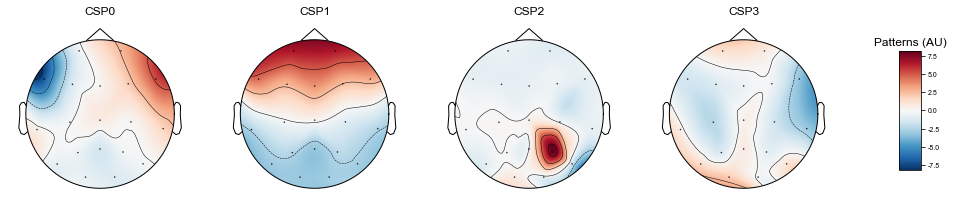

In [14]:
csp.plot_patterns(epochs_tmp.info,  ch_type='eeg', units='Patterns (AU)', size=2);

In [15]:
from scipy.signal import welch

po = []
for x in epochs_data:
    f,p = welch(np.dot(csp.filters_[0,:].T, x), fs=epochs_tmp.info['sfreq'], nperseg=None, noverlap=None)
    po.append(p)
po = np.array(po)

In [16]:
from mne.viz.topomap import _prepare_topo_plot
_, epos, _, _, _ = _prepare_topo_plot(epochs_tmp, 'eeg', None)

In [17]:
pattern = csp.patterns_[0,:]
pattern -= pattern.mean()
ix = np.argmax(abs(pattern))

if pattern[ix]>0:
    sign = 1.0
else:
    sign = -1.0

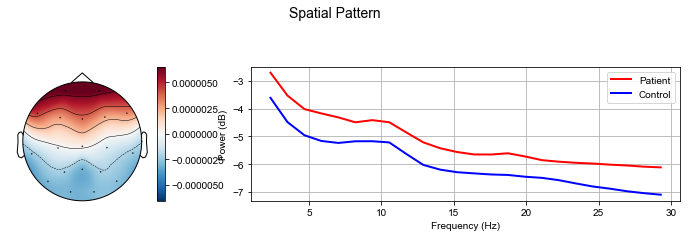

In [19]:
pattern = csp.patterns_[1,:]
sign = 1.0

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax_topo = plt.subplots(1, 1, figsize=(12, 4))
title = 'Spatial Pattern'
fig.suptitle(title, fontsize=14)
img, _ = mne.viz.plot_topomap(sign*pattern,epos,axes=ax_topo,show=False)
divider = make_axes_locatable(ax_topo)
# add axes for colorbar
ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(img, cax=ax_colorbar)

# plot spectrum
fix = (f>2) & (f<30)
ax_spectrum = divider.append_axes('right', size='300%', pad=1.2)
ax_spectrum.plot(f[fix],np.log(po[labels==1][:,fix].mean(axis=0).T),'-r',lw=2)
ax_spectrum.plot(f[fix],np.log(po[labels==0][:,fix].mean(axis=0).T),'-b',lw=2)
ax_spectrum.legend(['Patient', 'Control'])
ax_spectrum.set_xlabel('Frequency (Hz)')
ax_spectrum.set_ylabel('Power (dB)')
plt.grid()

In [ ]:
# let's look at the performance over time

In [41]:
sfreq = epochs_tmp.info['sfreq']
w_length = int(sfreq * 0.5) # running classifier: window lwngth
w_step = int(sfreq * 0.1)   # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

In [23]:
for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]
    X_train = csp.fit_transform(epochs_train[train_idx], y_train)
    X_test  = csp.transform(epochs_train[test_idx])
    
    # Fit classifier
    lda.fit(X_train, y_train)
    
    # Running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:,:,n:(n+w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change to None in 0.18, set it explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train[train_idx], y_train)
<ipython-input-23-f8b21f2b4d3f>:3: DeprecationWarning: rank defaults to "full" in 0.17 but will change t

In [37]:
# Plot the scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs_tmp.tmin

Text(0,0.5,'Classification accuracy')

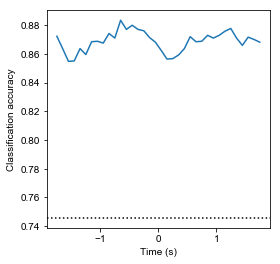

In [38]:
plt.figure(figsize=(4,4))
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axhline(class_balance, linestyle=':', color='k', label='Chance')
plt.xlabel('Time (s)')
plt.ylabel('Classification accuracy')